# 📊 Credit Risk Stratification - Exploratory Data Analysis

## Executive Summary

This notebook provides a comprehensive exploratory data analysis of the **German Credit Dataset** used in the Credit Risk Stratification & Repayment Cohort Analysis project.

### Dataset Overview
- **Total Records**: 22,903 transactions
- **Customers**: 1,000 unique profiles
- **Loans**: 1,000 active loan applications
- **Payments**: 20,903 repayment records

### Key Objectives
1. Understand customer demographics and credit profiles
2. Analyze loan characteristics and distribution
3. Examine payment behavior and delinquency patterns
4. Identify risk factors and correlations
5. Generate actionable insights for credit risk management

---

## Table of Contents
1. [Introduction & Setup](#setup)
2. [Data Loading & Overview](#loading)
3. [Customer Profile Analysis](#customer)
4. [Loan Application Analysis](#loan)
5. [Repayment History Analysis](#repayment)
6. [Bivariate Analysis](#bivariate)
7. [Multivariate Analysis](#multivariate)
8. [Risk Analysis](#risk)
9. [Time Series Analysis](#timeseries)
10. [Key Insights & Recommendations](#insights)

---

<a id='setup'></a>
## 1. Introduction & Setup

### Project Context
This analysis supports the **Credit Risk Stratification** project, demonstrating advanced SQL analytics, API development, and data visualization capabilities.

### Analysis Environment
- **Database**: MySQL 8.0+ (credit_risk_db)
- **Python**: 3.11+
- **Key Libraries**: pandas, numpy, matplotlib, seaborn, plotly, scipy

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pymysql
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Custom color palette
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'success': '#06A77D',
    'warning': '#F18F01',
    'danger': '#C73E1D',
    'info': '#6A4C93'
}

print("✅ Libraries imported successfully")
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries imported successfully
📅 Analysis Date: 2025-11-23 22:56:18


In [2]:
# Database connection setup
from dotenv import load_dotenv
import os

# Load environment variables
load_dotenv()

# Database configuration
db_config = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'user': os.getenv('DB_USER', 'root'),
    'password': os.getenv('DB_PASSWORD', ''),
    'database': os.getenv('DB_NAME', 'credit_risk_db')
}

# Test connection
try:
    connection = pymysql.connect(**db_config)
    print("✅ Database connection successful")
    print(f"📊 Connected to: {db_config['database']}")
    connection.close()
except Exception as e:
    print(f"❌ Connection failed: {e}")

✅ Database connection successful
📊 Connected to: credit_risk_db


<a id='loading'></a>
## 2. Data Loading & Overview

Loading all three tables from the MySQL database:
- **customer_profile**: Customer demographics and credit information
- **loan_application**: Loan details and approval information
- **repayment_history**: Payment transactions and delinquency records

In [3]:
# Function to load data from MySQL
def load_table(table_name):
    connection = pymysql.connect(**db_config)
    query = f"SELECT * FROM {table_name}"
    df = pd.read_sql(query, connection)
    connection.close()
    return df

# Load all tables
print("Loading data from MySQL...")
customers = load_table('customer_profile')
loans = load_table('loan_application')
payments = load_table('repayment_history')

print(f"\n✅ Data loaded successfully:")
print(f"   • Customers: {len(customers):,} records")
print(f"   • Loans: {len(loans):,} records")
print(f"   • Payments: {len(payments):,} records")
print(f"   • Total: {len(customers) + len(loans) + len(payments):,} records")

Loading data from MySQL...

✅ Data loaded successfully:
   • Customers: 1,000 records
   • Loans: 1,000 records
   • Payments: 20,903 records
   • Total: 22,903 records


In [4]:
# Display schema information
def display_schema(df, table_name):
    print(f"\n{'='*70}")
    print(f"TABLE: {table_name}")
    print(f"{'='*70}")
    print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
    print(f"Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"\nColumn Information:")
    print("-" * 70)
    
    schema_df = pd.DataFrame({
        'Column': df.columns,
        'Type': df.dtypes.values,
        'Non-Null': df.count().values,
        'Null %': ((df.isnull().sum() / len(df)) * 100).values.round(2),
        'Unique': [df[col].nunique() for col in df.columns]
    })
    print(schema_df.to_string(index=False))
    print("\n" + "="*70)

# Display schema for all tables
display_schema(customers, 'customer_profile')
display_schema(loans, 'loan_application')
display_schema(payments, 'repayment_history')


TABLE: customer_profile
Shape: 1,000 rows × 9 columns
Memory: 0.31 MB

Column Information:
----------------------------------------------------------------------
              Column    Type  Non-Null  Null %  Unique
         customer_id   int64      1000     0.0    1000
                 age   int64      1000     0.0      53
              gender  object      1000     0.0       2
              income float64      1000     0.0     996
     employment_type  object      1000     0.0       1
        credit_score   int64      1000     0.0     278
account_created_date  object      1000     0.0     640
      housing_status  object      1000     0.0       1
            job_type  object      1000     0.0       1


TABLE: loan_application
Shape: 1,000 rows × 10 columns
Memory: 0.25 MB

Column Information:
----------------------------------------------------------------------
             Column    Type  Non-Null  Null %  Unique
            loan_id   int64      1000     0.0    1000
        custom

In [5]:
# Preview data
print("\n📋 CUSTOMER PROFILE - Sample Records")
print("="*70)
display(customers.head())

print("\n📋 LOAN APPLICATION - Sample Records")
print("="*70)
display(loans.head())

print("\n📋 REPAYMENT HISTORY - Sample Records")
print("="*70)
display(payments.head())


📋 CUSTOMER PROFILE - Sample Records


,customer_id,age,gender,income,employment_type,credit_score,account_created_date,housing_status,job_type
0,1,67,Female,681.21,Unknown,815,2025-04-05,Unknown,Unknown
1,2,22,Male,3343.84,Unknown,680,2023-08-01,Unknown,Unknown
2,3,49,Male,725.78,Unknown,681,2025-02-13,Unknown,Unknown
3,4,45,Male,3652.05,Unknown,708,2025-07-30,Unknown,Unknown
4,5,53,Female,2317.54,Unknown,697,2024-10-05,Unknown,Unknown



📋 LOAN APPLICATION - Sample Records


,loan_id,customer_id,loan_amount,loan_type,interest_rate,loan_term_months,application_date,approval_date,loan_status,monthly_installment
0,1,1,1169.0,Personal,7.54,6,2025-06-01,2025-06-02,Approved,196.06
1,2,2,5951.0,Personal,10.48,48,2024-03-22,2024-03-30,Approved,125.06
2,3,3,2096.0,Personal,16.30,12,2023-12-12,2023-12-14,Approved,177.04
3,4,4,7882.0,Personal,6.43,42,2025-04-01,2025-04-11,Approved,188.67
4,5,5,4870.0,Personal,8.72,24,2025-07-13,2025-07-20,Approved,204.39



📋 REPAYMENT HISTORY - Sample Records


,payment_id,loan_id,installment_number,installment_amount,due_date,actual_paid_date,amount_paid,payment_status,days_past_due
0,1,1,1,196.06,2025-07-02,2025-07-02,196.06,On Time,0
1,2,1,2,196.06,2025-08-01,2025-09-20,196.06,Missed,50
2,3,1,3,196.06,2025-08-31,2025-08-31,196.06,On Time,0
3,4,1,4,196.06,2025-09-30,2025-09-28,196.06,On Time,0
4,5,1,5,196.06,2025-10-30,2025-10-30,196.06,On Time,0


In [6]:
# Data quality assessment
def assess_data_quality(df, table_name):
    print(f"\n🔍 DATA QUALITY ASSESSMENT: {table_name}")
    print("="*70)
    
    # Missing values
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"⚠️  Missing Values Detected:")
        print(missing[missing > 0])
    else:
        print("✅ No missing values")
    
    # Duplicates
    duplicates = df.duplicated().sum()
    print(f"\n{'✅' if duplicates == 0 else '⚠️ '} Duplicate Rows: {duplicates}")
    
    # Data types
    print(f"\n📊 Data Types:")
    print(df.dtypes.value_counts())
    
    print("="*70)

# Assess all tables
assess_data_quality(customers, 'customer_profile')
assess_data_quality(loans, 'loan_application')
assess_data_quality(payments, 'repayment_history')


🔍 DATA QUALITY ASSESSMENT: customer_profile
✅ No missing values

✅ Duplicate Rows: 0

📊 Data Types:
object     5
int64      3
float64    1
Name: count, dtype: int64

🔍 DATA QUALITY ASSESSMENT: loan_application
✅ No missing values

✅ Duplicate Rows: 0

📊 Data Types:
object     4
int64      3
float64    3
Name: count, dtype: int64

🔍 DATA QUALITY ASSESSMENT: repayment_history
✅ No missing values

✅ Duplicate Rows: 0

📊 Data Types:
int64      4
object     3
float64    2
Name: count, dtype: int64


<a id='customer'></a>
## 3. Customer Profile Analysis (Univariate)

Analyzing customer demographics, credit scores, and socioeconomic factors.

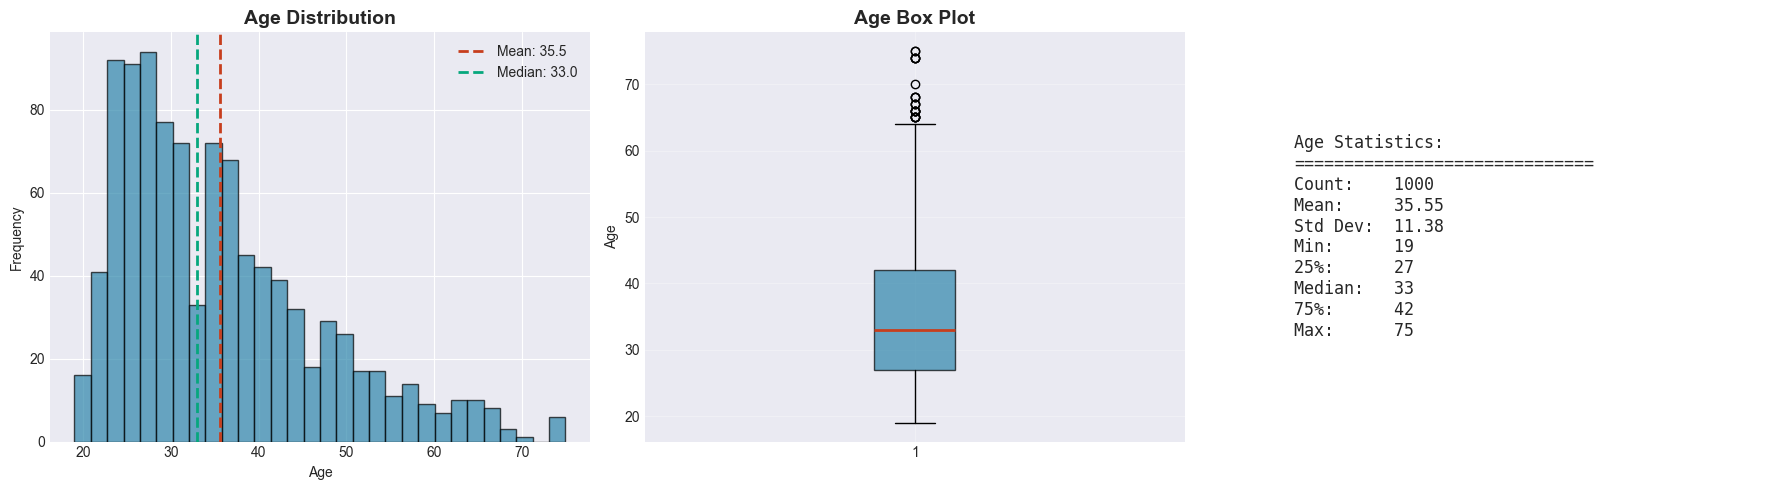


📊 Age Insights:
   • Average customer age: 35.5 years
   • Age range: 19 - 75 years
   • Most common age group: 27 years


In [7]:
# Age distribution analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Histogram
axes[0].hist(customers['age'], bins=30, color=COLORS['primary'], alpha=0.7, edgecolor='black')
axes[0].set_title('Age Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')
axes[0].axvline(customers['age'].mean(), color=COLORS['danger'], linestyle='--', linewidth=2, label=f'Mean: {customers["age"].mean():.1f}')
axes[0].axvline(customers['age'].median(), color=COLORS['success'], linestyle='--', linewidth=2, label=f'Median: {customers["age"].median():.1f}')
axes[0].legend()

# Box plot
axes[1].boxplot(customers['age'], vert=True, patch_artist=True,
                boxprops=dict(facecolor=COLORS['primary'], alpha=0.7),
                medianprops=dict(color=COLORS['danger'], linewidth=2))
axes[1].set_title('Age Box Plot', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Age')
axes[1].grid(True, alpha=0.3)

# Statistics
age_stats = customers['age'].describe()
axes[2].axis('off')
stats_text = f"""
Age Statistics:
{'='*30}
Count:    {age_stats['count']:.0f}
Mean:     {age_stats['mean']:.2f}
Std Dev:  {age_stats['std']:.2f}
Min:      {age_stats['min']:.0f}
25%:      {age_stats['25%']:.0f}
Median:   {age_stats['50%']:.0f}
75%:      {age_stats['75%']:.0f}
Max:      {age_stats['max']:.0f}
"""
axes[2].text(0.1, 0.5, stats_text, fontsize=12, family='monospace', verticalalignment='center')

plt.tight_layout()
plt.show()

print(f"\n📊 Age Insights:")
print(f"   • Average customer age: {customers['age'].mean():.1f} years")
print(f"   • Age range: {customers['age'].min():.0f} - {customers['age'].max():.0f} years")
print(f"   • Most common age group: {customers['age'].mode().values[0]:.0f} years")

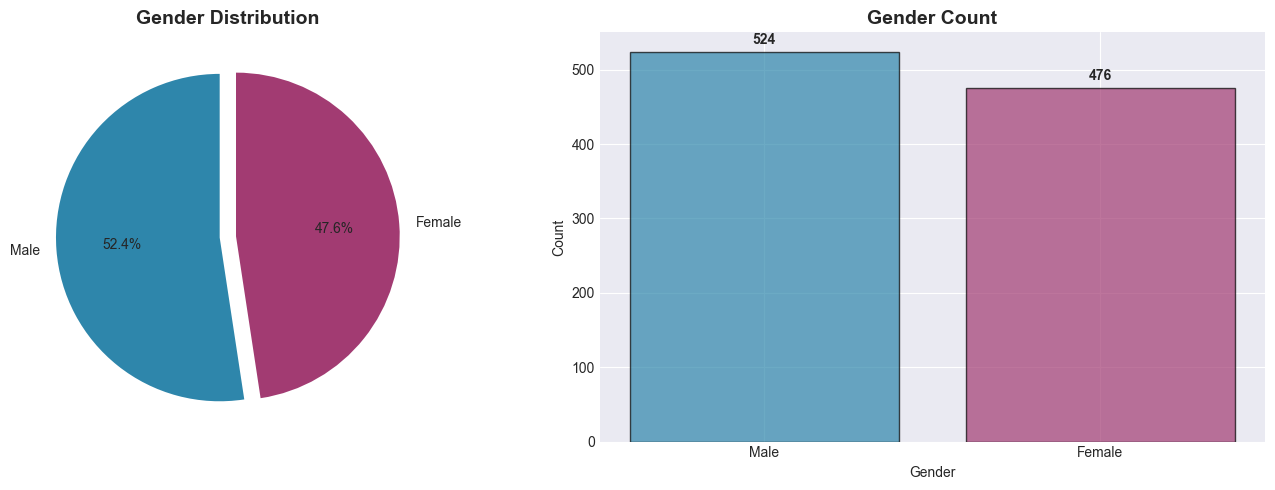


📊 Gender Insights:
   • Male: 524 (52.4%)
   • Female: 476 (47.6%)


In [8]:
# Gender distribution
gender_counts = customers['gender'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
colors_pie = [COLORS['primary'], COLORS['secondary']]
axes[0].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%',
            startangle=90, colors=colors_pie, explode=(0.05, 0.05))
axes[0].set_title('Gender Distribution', fontsize=14, fontweight='bold')

# Bar chart
axes[1].bar(gender_counts.index, gender_counts.values, color=colors_pie, alpha=0.7, edgecolor='black')
axes[1].set_title('Gender Count', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Gender')
for i, v in enumerate(gender_counts.values):
    axes[1].text(i, v + 10, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Gender Insights:")
for gender, count in gender_counts.items():
    print(f"   • {gender}: {count} ({count/len(customers)*100:.1f}%)")

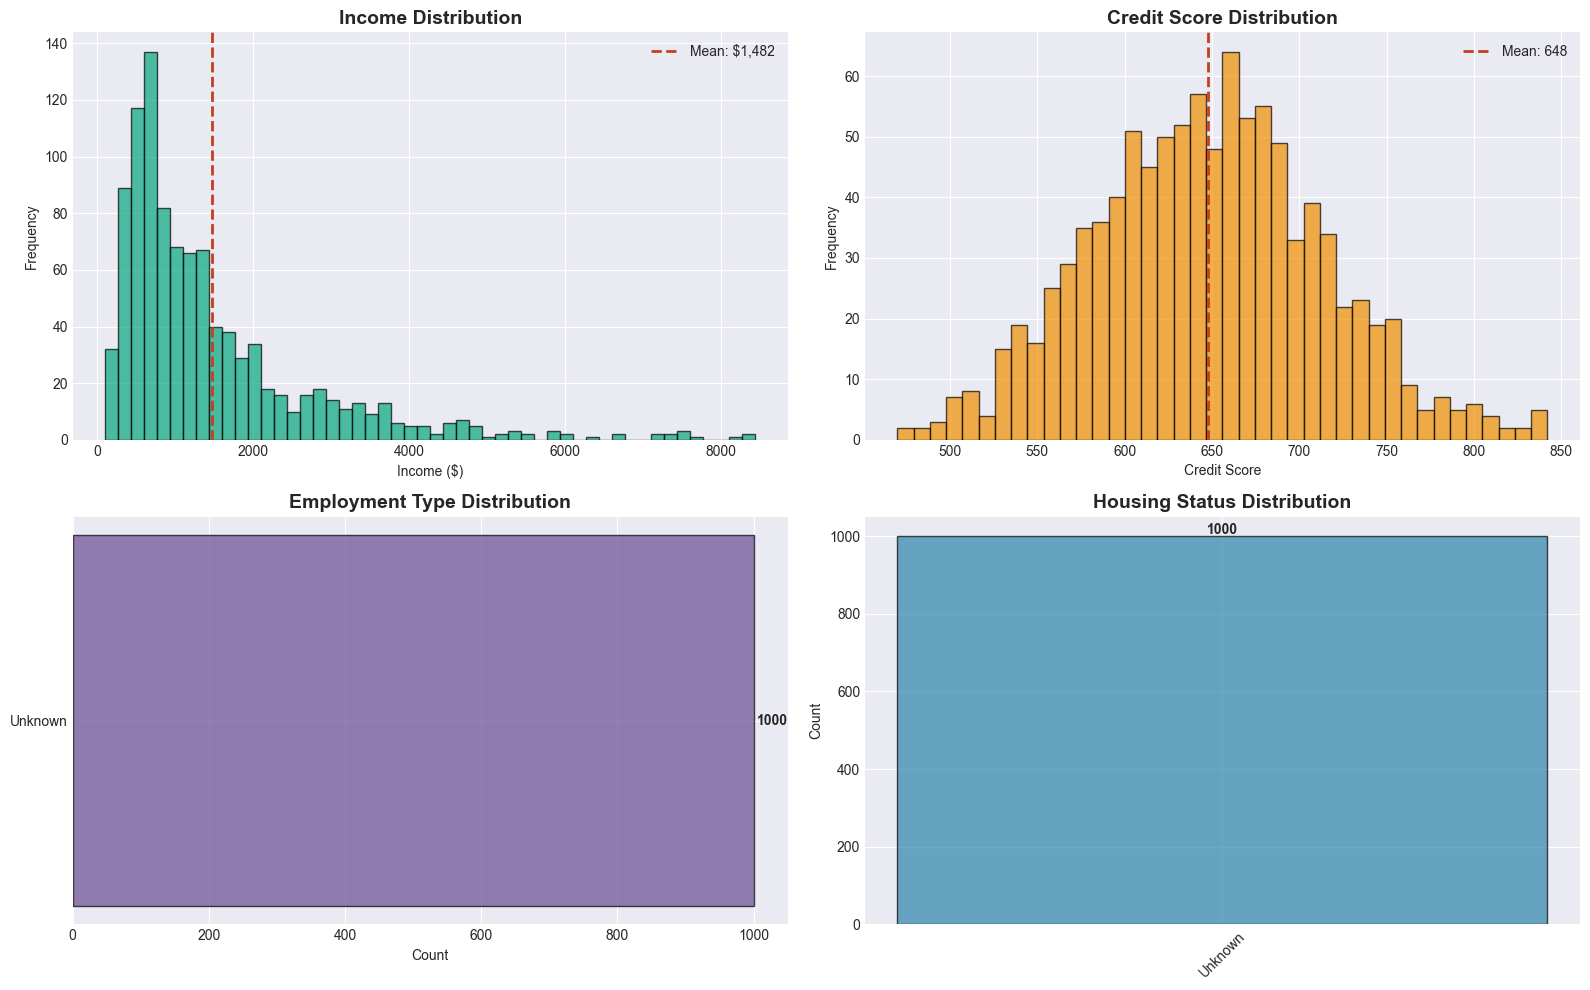


📊 Customer Profile Summary:
   • Average income: $1,482.25
   • Average credit score: 648
   • Most common employment: Unknown
   • Most common housing: Unknown


In [ ]:
# Income and Credit Score Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Income histogram
axes[0, 0].hist(customers['income'], bins=50, color=COLORS['success'], alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Income Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Income ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(customers['income'].mean(), color=COLORS['danger'], linestyle='--', linewidth=2, label=f'Mean: ${customers["income"].mean():,.0f}')
axes[0, 0].legend()

# Credit score histogram
axes[0, 1].hist(customers['credit_score'], bins=40, color=COLORS['warning'], alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Credit Score Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Credit Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(customers['credit_score'].mean(), color=COLORS['danger'], linestyle='--', linewidth=2, label=f'Mean: {customers["credit_score"].mean():.0f}')
axes[0, 1].legend()



plt.tight_layout()
plt.show()

print(f"\n📊 Customer Profile Summary:")
print(f"   • Average income: ${customers['income'].mean():,.2f}")
print(f"   • Average credit score: {customers['credit_score'].mean():.0f}")


<a id='loan'></a>
## 4. Loan Application Analysis (Univariate)

Analyzing loan amounts, types, interest rates, and approval patterns.

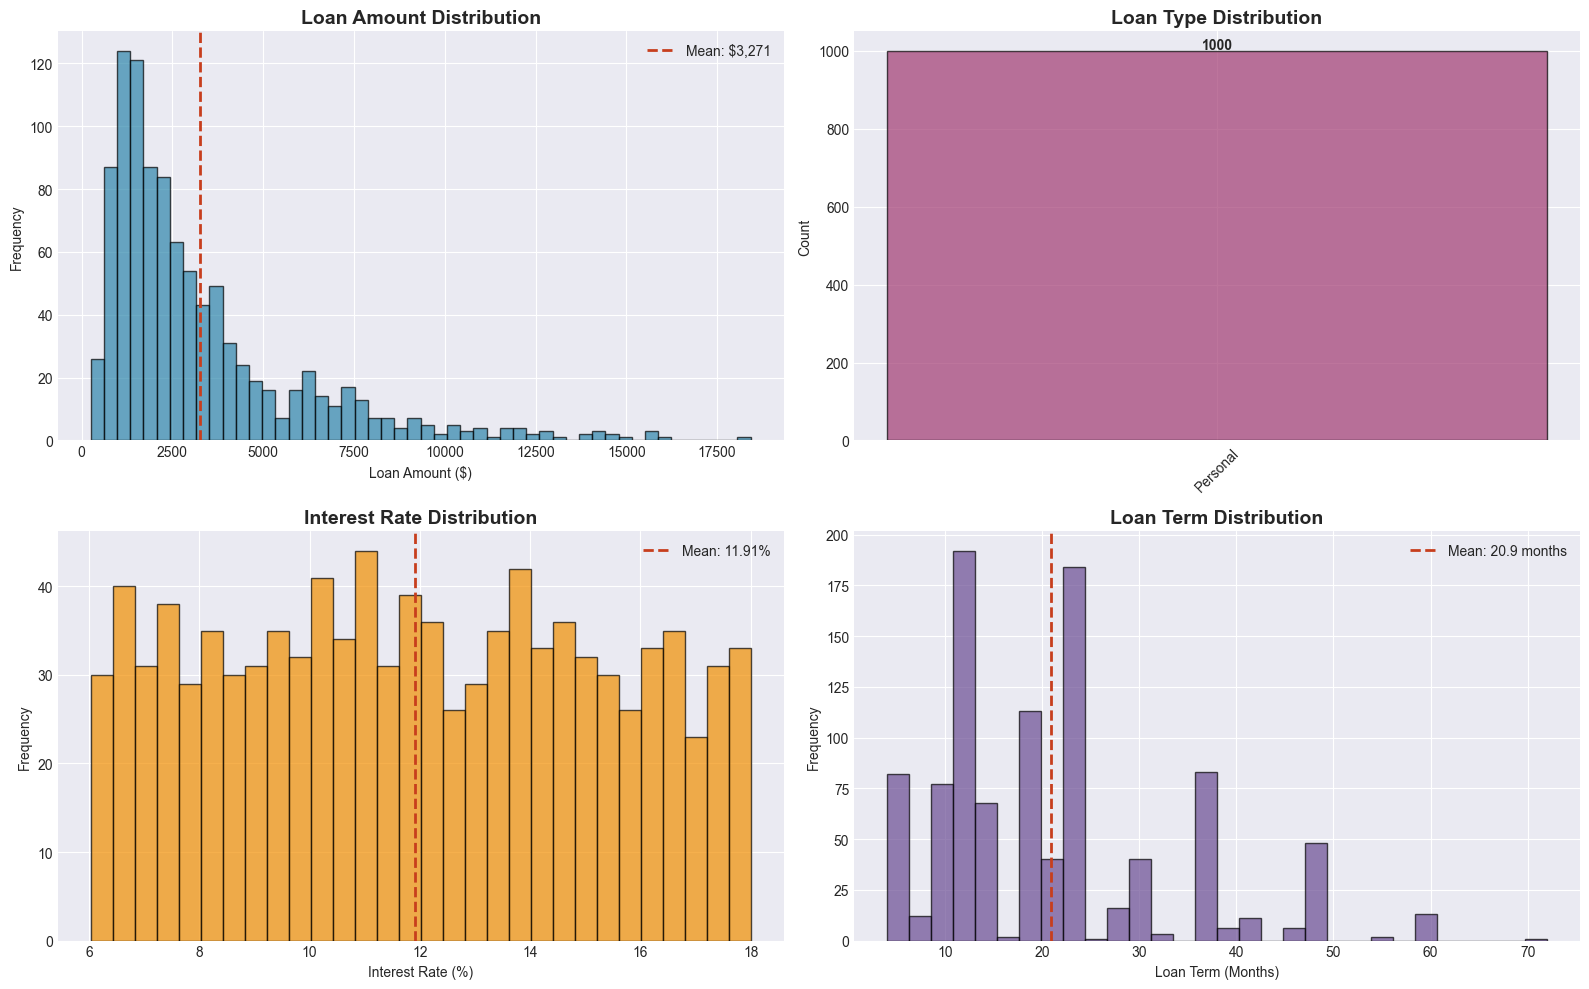


📊 Loan Application Summary:
   • Average loan: $3,271.26
   • Total portfolio value: $3,271,258.00
   • Average interest rate: 11.91%
   • Average term: 20.9 months
   • Most common loan type: Personal


In [10]:
# Loan amount and type analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Loan amount histogram
axes[0, 0].hist(loans['loan_amount'], bins=50, color=COLORS['primary'], alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Loan Amount Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Loan Amount ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(loans['loan_amount'].mean(), color=COLORS['danger'], linestyle='--', linewidth=2, label=f'Mean: ${loans["loan_amount"].mean():,.0f}')
axes[0, 0].legend()

# Loan type distribution
loan_type_counts = loans['loan_type'].value_counts()
axes[0, 1].bar(loan_type_counts.index, loan_type_counts.values, color=COLORS['secondary'], alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Loan Type Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(loan_type_counts.values):
    axes[0, 1].text(i, v + 5, str(v), ha='center', fontweight='bold')

# Interest rate histogram
axes[1, 0].hist(loans['interest_rate'], bins=30, color=COLORS['warning'], alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Interest Rate Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Interest Rate (%)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(loans['interest_rate'].mean(), color=COLORS['danger'], linestyle='--', linewidth=2, label=f'Mean: {loans["interest_rate"].mean():.2f}%')
axes[1, 0].legend()

# Loan term histogram
axes[1, 1].hist(loans['loan_term_months'], bins=30, color=COLORS['info'], alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Loan Term Distribution', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Loan Term (Months)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(loans['loan_term_months'].mean(), color=COLORS['danger'], linestyle='--', linewidth=2, label=f'Mean: {loans["loan_term_months"].mean():.1f} months')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print(f"\n📊 Loan Application Summary:")
print(f"   • Average loan: ${loans['loan_amount'].mean():,.2f}")
print(f"   • Total portfolio value: ${loans['loan_amount'].sum():,.2f}")
print(f"   • Average interest rate: {loans['interest_rate'].mean():.2f}%")
print(f"   • Average term: {loans['loan_term_months'].mean():.1f} months")
print(f"   • Most common loan type: {loan_type_counts.index[0]}")

<a id='repayment'></a>
## 5. Repayment History Analysis (Univariate)

Analyzing payment behavior, delinquency patterns, and payment status distribution.

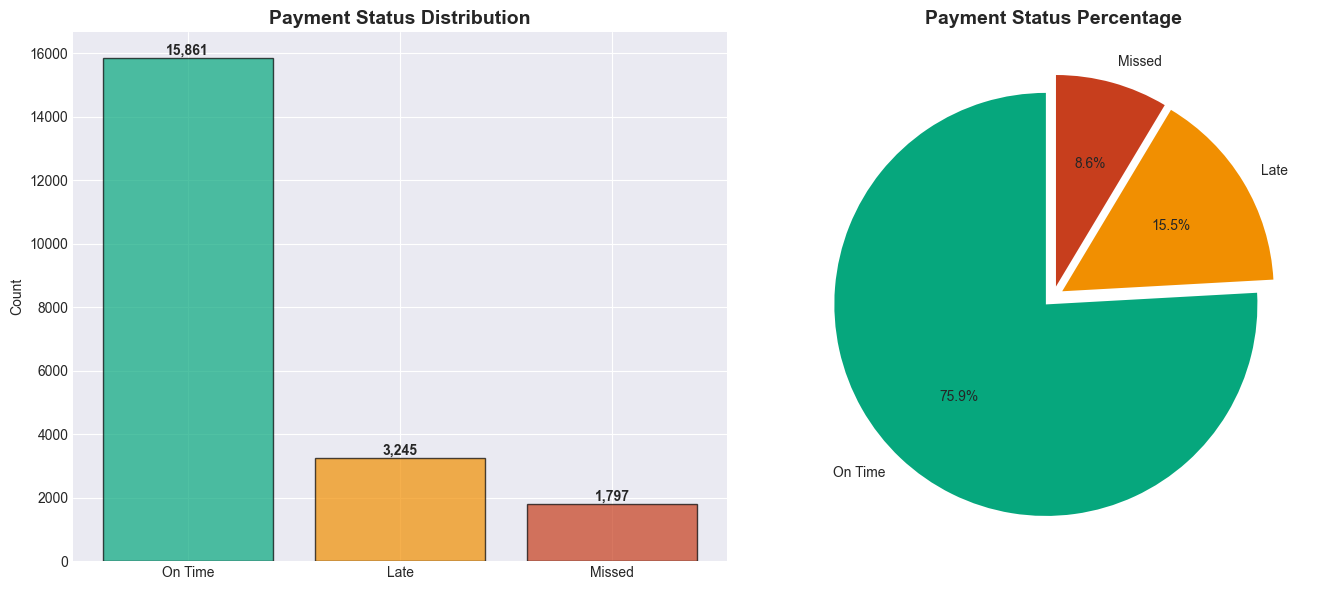


📊 Payment Status Summary:
   Total Payments: 20,903
   • On Time: 15,861 (75.9%)
   • Late: 3,245 (15.5%)
   • Missed: 1,797 (8.6%)

   ✅ On-Time Payment Rate: 75.9%


In [11]:
# Payment status distribution
status_counts = payments['payment_status'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart
axes[0].bar(status_counts.index, status_counts.values, color=[COLORS['success'], COLORS['warning'], COLORS['danger']], alpha=0.7, edgecolor='black')
axes[0].set_title('Payment Status Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count')
for i, v in enumerate(status_counts.values):
    axes[0].text(i, v + 100, f'{v:,}', ha='center', fontweight='bold')

# Pie chart
colors_status = [COLORS['success'], COLORS['warning'], COLORS['danger']]
axes[1].pie(status_counts.values, labels=status_counts.index, autopct='%1.1f%%',
            startangle=90, colors=colors_status, explode=(0.05, 0.05, 0.05))
axes[1].set_title('Payment Status Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Payment Status Summary:")
print(f"   Total Payments: {len(payments):,}")
for status, count in status_counts.items():
    print(f"   • {status}: {count:,} ({count/len(payments)*100:.1f}%)")

# Calculate on-time rate
on_time_rate = (status_counts.get('On Time', 0) / len(payments)) * 100
print(f"\n   ✅ On-Time Payment Rate: {on_time_rate:.1f}%")

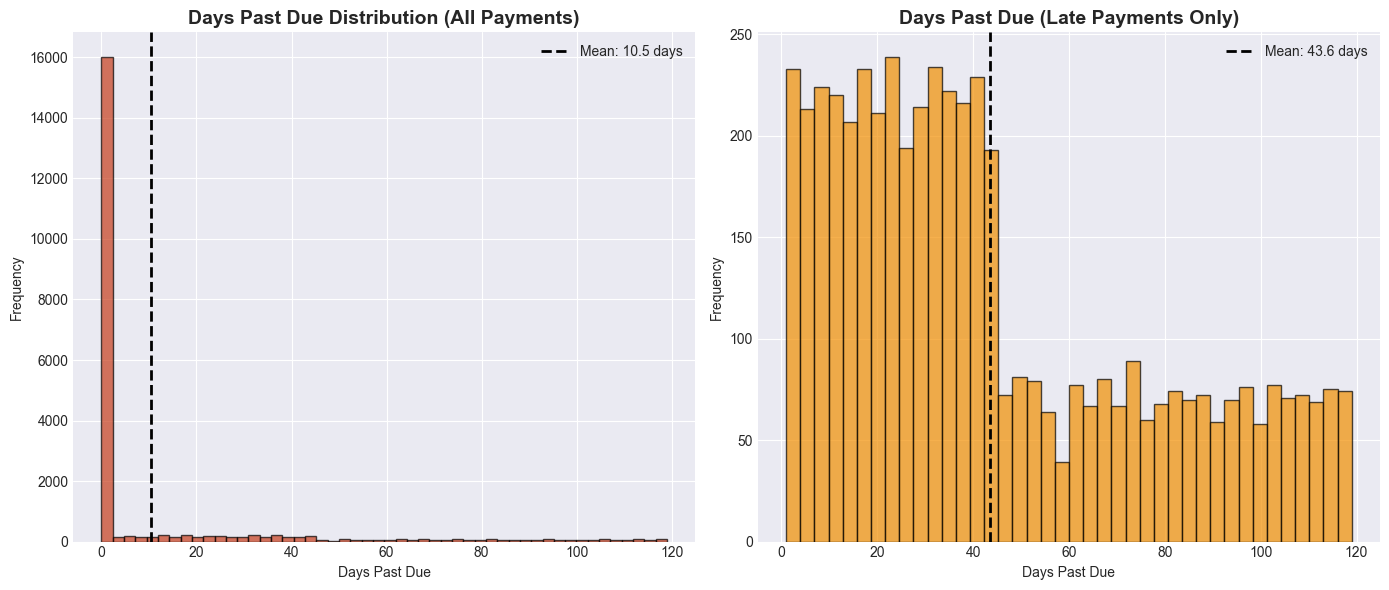


📊 Delinquency Summary:
   • Total payments: 20,903
   • Late payments: 5,042 (24.1%)
   • Average delay (late payments): 43.6 days
   • Maximum delay: 119 days


In [12]:
# Days past due analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# All payments
axes[0].hist(payments['days_past_due'], bins=50, color=COLORS['danger'], alpha=0.7, edgecolor='black')
axes[0].set_title('Days Past Due Distribution (All Payments)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Days Past Due')
axes[0].set_ylabel('Frequency')
axes[0].axvline(payments['days_past_due'].mean(), color='black', linestyle='--', linewidth=2, label=f'Mean: {payments["days_past_due"].mean():.1f} days')
axes[0].legend()

# Late payments only
late_payments = payments[payments['days_past_due'] > 0]
axes[1].hist(late_payments['days_past_due'], bins=40, color=COLORS['warning'], alpha=0.7, edgecolor='black')
axes[1].set_title('Days Past Due (Late Payments Only)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Days Past Due')
axes[1].set_ylabel('Frequency')
axes[1].axvline(late_payments['days_past_due'].mean(), color='black', linestyle='--', linewidth=2, label=f'Mean: {late_payments["days_past_due"].mean():.1f} days')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n📊 Delinquency Summary:")
print(f"   • Total payments: {len(payments):,}")
print(f"   • Late payments: {len(late_payments):,} ({len(late_payments)/len(payments)*100:.1f}%)")
print(f"   • Average delay (late payments): {late_payments['days_past_due'].mean():.1f} days")
print(f"   • Maximum delay: {late_payments['days_past_due'].max():.0f} days")

<a id='bivariate'></a>
## 6. Bivariate Analysis (Relationships)

Exploring relationships between key variables.

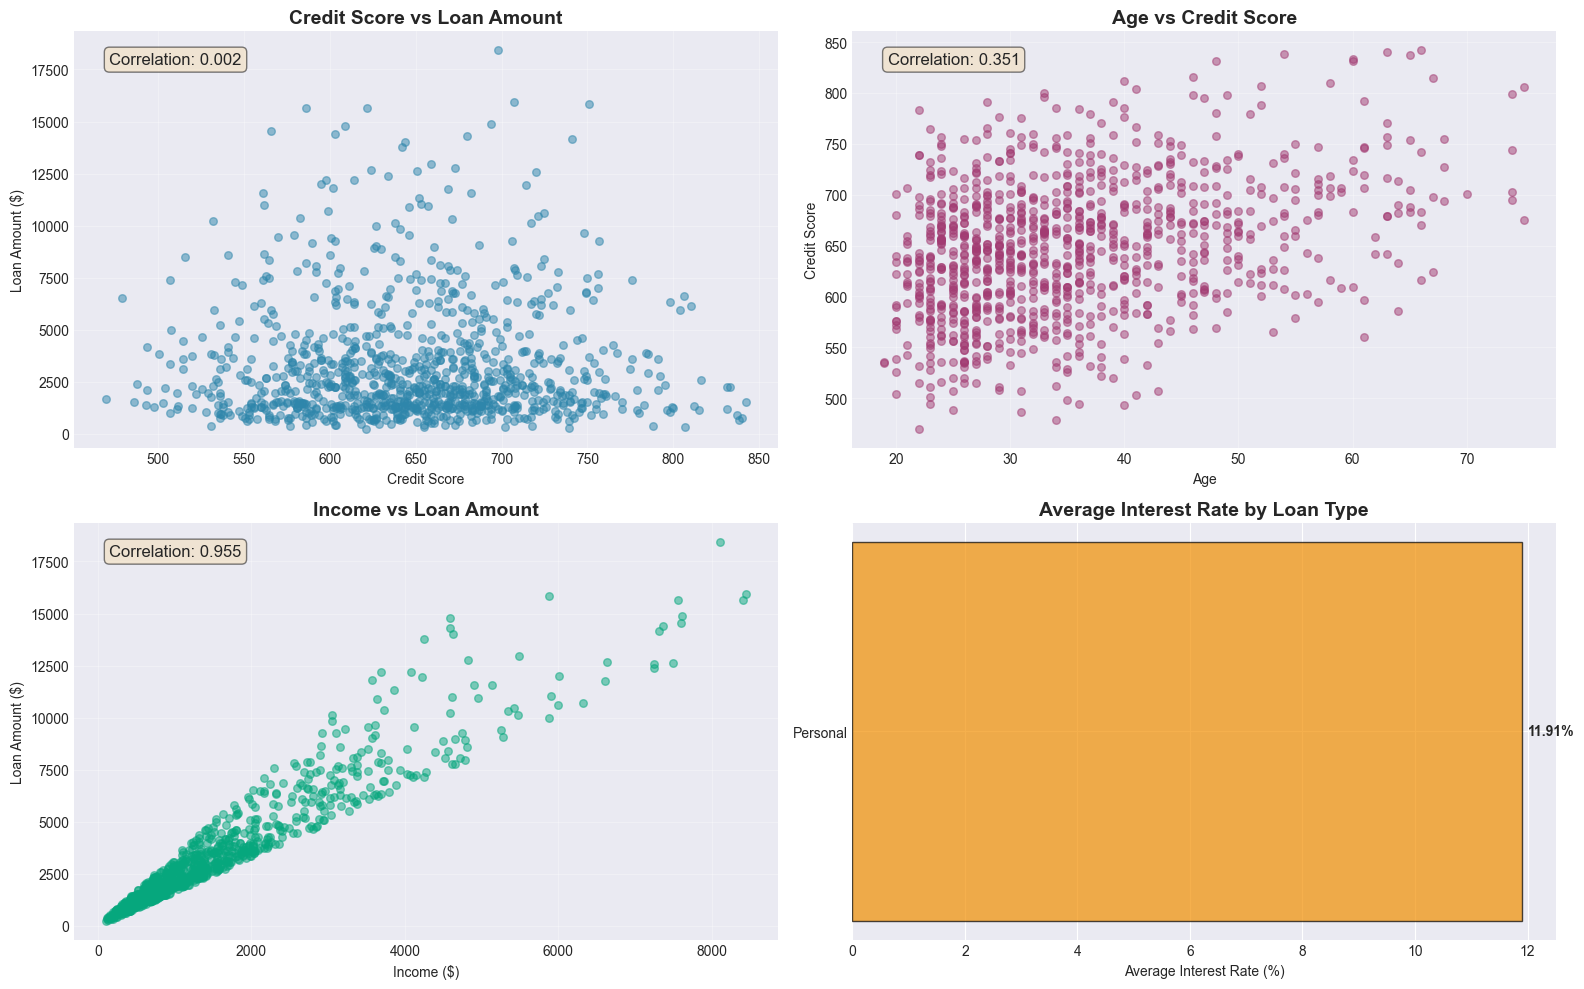


📊 Bivariate Analysis Summary:
   • Credit Score vs Loan Amount correlation: 0.002
   • Age vs Credit Score correlation: 0.351
   • Income vs Loan Amount correlation: 0.955


In [13]:
# Credit score vs loan amount
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Merge customers and loans
customer_loans = customers.merge(loans, on='customer_id')

# Credit score vs loan amount
axes[0, 0].scatter(customer_loans['credit_score'], customer_loans['loan_amount'], alpha=0.5, color=COLORS['primary'], s=30)
axes[0, 0].set_title('Credit Score vs Loan Amount', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Credit Score')
axes[0, 0].set_ylabel('Loan Amount ($)')
axes[0, 0].grid(True, alpha=0.3)

# Calculate correlation
corr = customer_loans['credit_score'].corr(customer_loans['loan_amount'])
axes[0, 0].text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=axes[0, 0].transAxes, 
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Age vs credit score
axes[0, 1].scatter(customer_loans['age'], customer_loans['credit_score'], alpha=0.5, color=COLORS['secondary'], s=30)
axes[0, 1].set_title('Age vs Credit Score', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Credit Score')
axes[0, 1].grid(True, alpha=0.3)

corr2 = customer_loans['age'].corr(customer_loans['credit_score'])
axes[0, 1].text(0.05, 0.95, f'Correlation: {corr2:.3f}', transform=axes[0, 1].transAxes, 
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Income vs loan amount
axes[1, 0].scatter(customer_loans['income'], customer_loans['loan_amount'], alpha=0.5, color=COLORS['success'], s=30)
axes[1, 0].set_title('Income vs Loan Amount', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Income ($)')
axes[1, 0].set_ylabel('Loan Amount ($)')
axes[1, 0].grid(True, alpha=0.3)

corr3 = customer_loans['income'].corr(customer_loans['loan_amount'])
axes[1, 0].text(0.05, 0.95, f'Correlation: {corr3:.3f}', transform=axes[1, 0].transAxes, 
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Loan type vs interest rate
loan_type_rate = customer_loans.groupby('loan_type')['interest_rate'].mean().sort_values()
axes[1, 1].barh(loan_type_rate.index, loan_type_rate.values, color=COLORS['warning'], alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Average Interest Rate by Loan Type', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Average Interest Rate (%)')
for i, v in enumerate(loan_type_rate.values):
    axes[1, 1].text(v + 0.1, i, f'{v:.2f}%', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Bivariate Analysis Summary:")
print(f"   • Credit Score vs Loan Amount correlation: {corr:.3f}")
print(f"   • Age vs Credit Score correlation: {corr2:.3f}")
print(f"   • Income vs Loan Amount correlation: {corr3:.3f}")

<a id='multivariate'></a>
## 7. Multivariate Analysis

Correlation analysis and feature relationships.

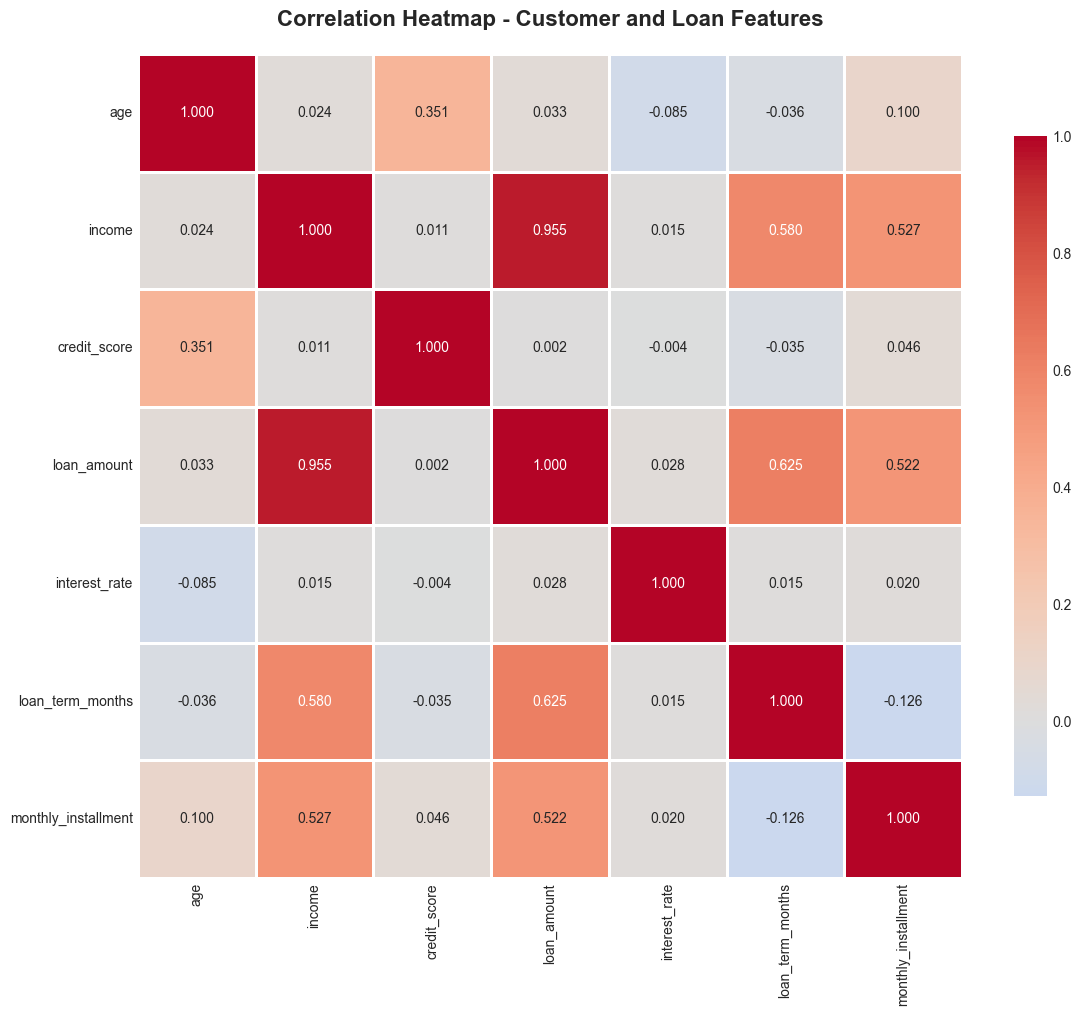


📊 Correlation Matrix:
                          age    income  credit_score  loan_amount  \
age                  1.000000  0.024304      0.351307     0.032716   
income               0.024304  1.000000      0.010706     0.955211   
credit_score         0.351307  0.010706      1.000000     0.001559   
loan_amount          0.032716  0.955211      0.001559     1.000000   
interest_rate       -0.085465  0.014719     -0.003938     0.028497   
loan_term_months    -0.036136  0.580381     -0.034630     0.624984   
monthly_installment  0.099901  0.527039      0.046350     0.522004   

                     interest_rate  loan_term_months  monthly_installment  
age                      -0.085465         -0.036136             0.099901  
income                    0.014719          0.580381             0.527039  
credit_score             -0.003938         -0.034630             0.046350  
loan_amount               0.028497          0.624984             0.522004  
interest_rate             1.000000  

In [14]:
# Correlation heatmap
numeric_cols = ['age', 'income', 'credit_score', 'loan_amount', 'interest_rate', 'loan_term_months', 'monthly_installment']
corr_matrix = customer_loans[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap - Customer and Loan Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\n📊 Correlation Matrix:")
print(corr_matrix)

# Find strongest correlations
corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

print("\n📊 Top 5 Strongest Correlations:")
for i, (var1, var2, corr_val) in enumerate(corr_pairs[:5], 1):
    print(f"   {i}. {var1} vs {var2}: {corr_val:.3f}")

<a id='risk'></a>
## 8. Risk Analysis

Credit risk stratification and payment behavior by risk tier.

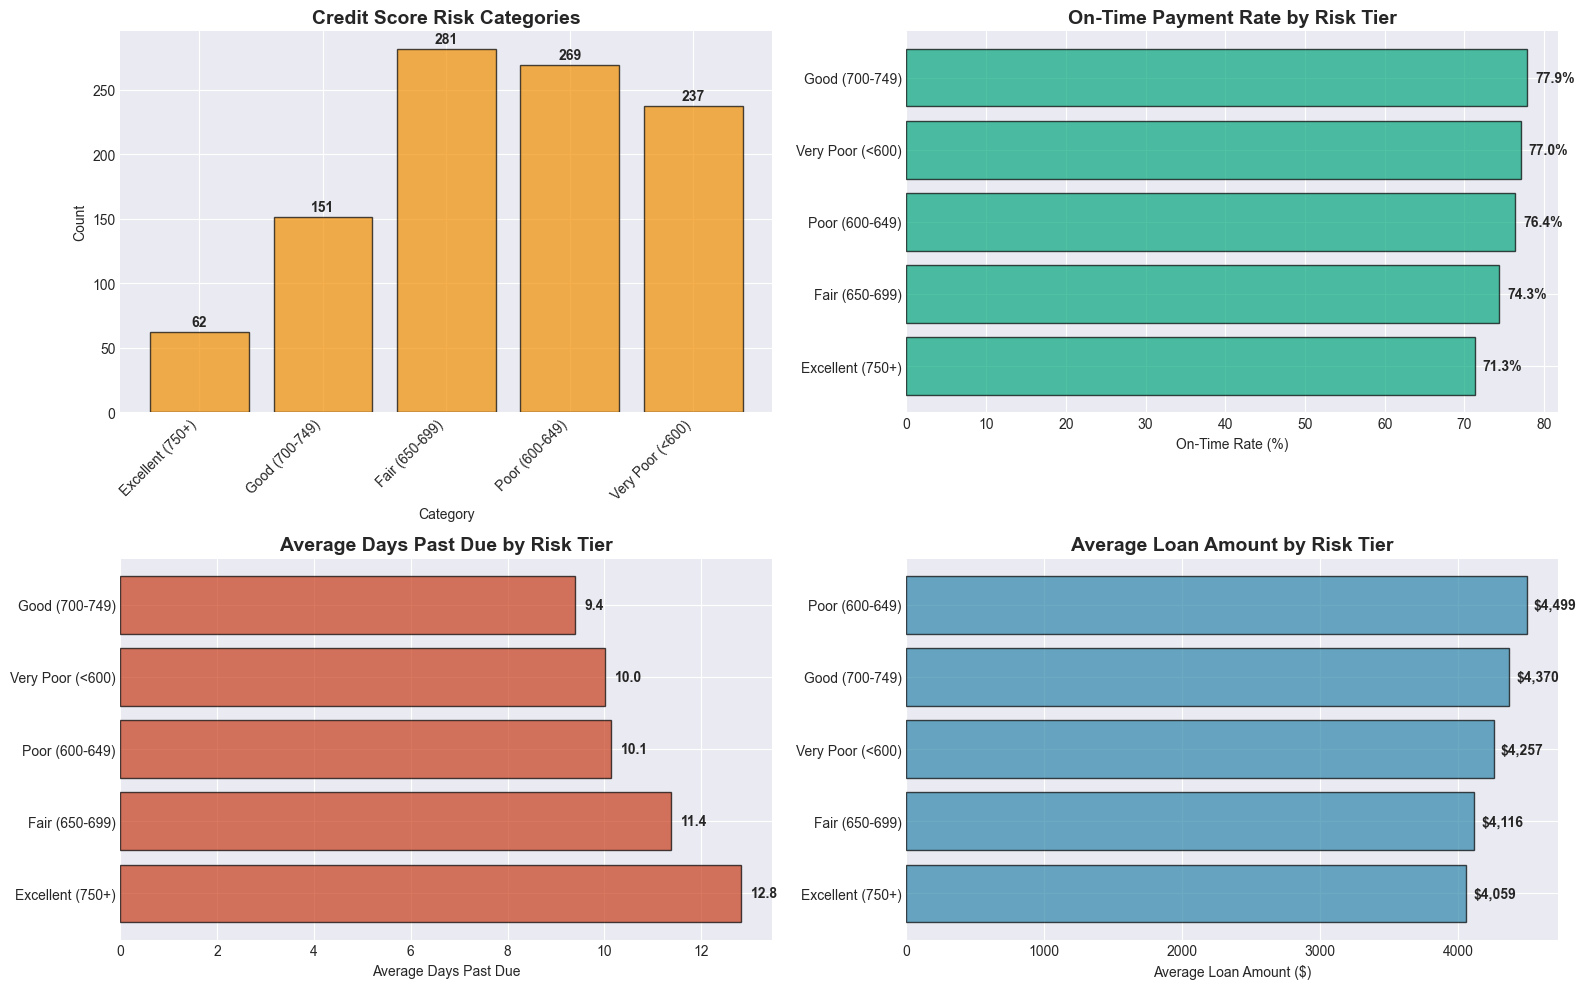


📊 Risk Analysis Summary:
       Risk Tier  On-Time Rate (%)  Avg Days Past Due  Avg Loan Amount  Avg Interest Rate
Excellent (750+)         71.261487          12.829574      4058.697577          12.273091
  Fair (650-699)         74.341774          11.382022      4116.419587          11.684384
  Good (700-749)         77.850163           9.384365      4369.590228          12.198117
  Poor (600-649)         76.379613          10.144640      4499.379086          12.369975
Very Poor (<600)         77.041943          10.011840      4256.673089          11.500963


In [15]:
# Risk stratification
def categorize_credit_score(score):
    if score >= 750:
        return 'Excellent (750+)'
    elif score >= 700:
        return 'Good (700-749)'
    elif score >= 650:
        return 'Fair (650-699)'
    elif score >= 600:
        return 'Poor (600-649)'
    else:
        return 'Very Poor (<600)'

customers['credit_category'] = customers['credit_score'].apply(categorize_credit_score)
customer_loans['credit_category'] = customer_loans['credit_score'].apply(categorize_credit_score)

# Merge with payments to analyze payment behavior by risk tier
loan_payments = loans.merge(payments, on='loan_id')
customer_loan_payments = customer_loans.merge(payments, on='loan_id')

# Calculate payment metrics by risk tier
risk_metrics = customer_loan_payments.groupby('credit_category').agg({
    'payment_status': lambda x: (x == 'On Time').sum() / len(x) * 100,
    'days_past_due': 'mean',
    'loan_amount': 'mean',
    'interest_rate': 'mean'
}).reset_index()
risk_metrics.columns = ['Risk Tier', 'On-Time Rate (%)', 'Avg Days Past Due', 'Avg Loan Amount', 'Avg Interest Rate']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Risk tier distribution
category_counts = customers['credit_category'].value_counts()
category_order = ['Excellent (750+)', 'Good (700-749)', 'Fair (650-699)', 'Poor (600-649)', 'Very Poor (<600)']
category_counts = category_counts.reindex([c for c in category_order if c in category_counts.index])

axes[0, 0].bar(range(len(category_counts)), category_counts.values, color=COLORS['warning'], alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Credit Score Risk Categories', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Category')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xticks(range(len(category_counts)))
axes[0, 0].set_xticklabels(category_counts.index, rotation=45, ha='right')
for i, v in enumerate(category_counts.values):
    axes[0, 0].text(i, v + 5, str(v), ha='center', fontweight='bold')

# On-time rate by risk tier
risk_metrics_sorted = risk_metrics.sort_values('On-Time Rate (%)', ascending=True)
axes[0, 1].barh(risk_metrics_sorted['Risk Tier'], risk_metrics_sorted['On-Time Rate (%)'], 
                color=COLORS['success'], alpha=0.7, edgecolor='black')
axes[0, 1].set_title('On-Time Payment Rate by Risk Tier', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('On-Time Rate (%)')
for i, v in enumerate(risk_metrics_sorted['On-Time Rate (%)']):
    axes[0, 1].text(v + 1, i, f'{v:.1f}%', va='center', fontweight='bold')

# Average days past due by risk tier
risk_metrics_sorted2 = risk_metrics.sort_values('Avg Days Past Due', ascending=False)
axes[1, 0].barh(risk_metrics_sorted2['Risk Tier'], risk_metrics_sorted2['Avg Days Past Due'], 
                color=COLORS['danger'], alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Average Days Past Due by Risk Tier', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Average Days Past Due')
for i, v in enumerate(risk_metrics_sorted2['Avg Days Past Due']):
    axes[1, 0].text(v + 0.2, i, f'{v:.1f}', va='center', fontweight='bold')

# Average loan amount by risk tier
risk_metrics_sorted3 = risk_metrics.sort_values('Avg Loan Amount', ascending=True)
axes[1, 1].barh(risk_metrics_sorted3['Risk Tier'], risk_metrics_sorted3['Avg Loan Amount'], 
                color=COLORS['primary'], alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Average Loan Amount by Risk Tier', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Average Loan Amount ($)')
for i, v in enumerate(risk_metrics_sorted3['Avg Loan Amount']):
    axes[1, 1].text(v + 50, i, f'${v:,.0f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Risk Analysis Summary:")
print(risk_metrics.to_string(index=False))

<a id='timeseries'></a>
## 9. Time Series Analysis

Payment trends and temporal patterns.

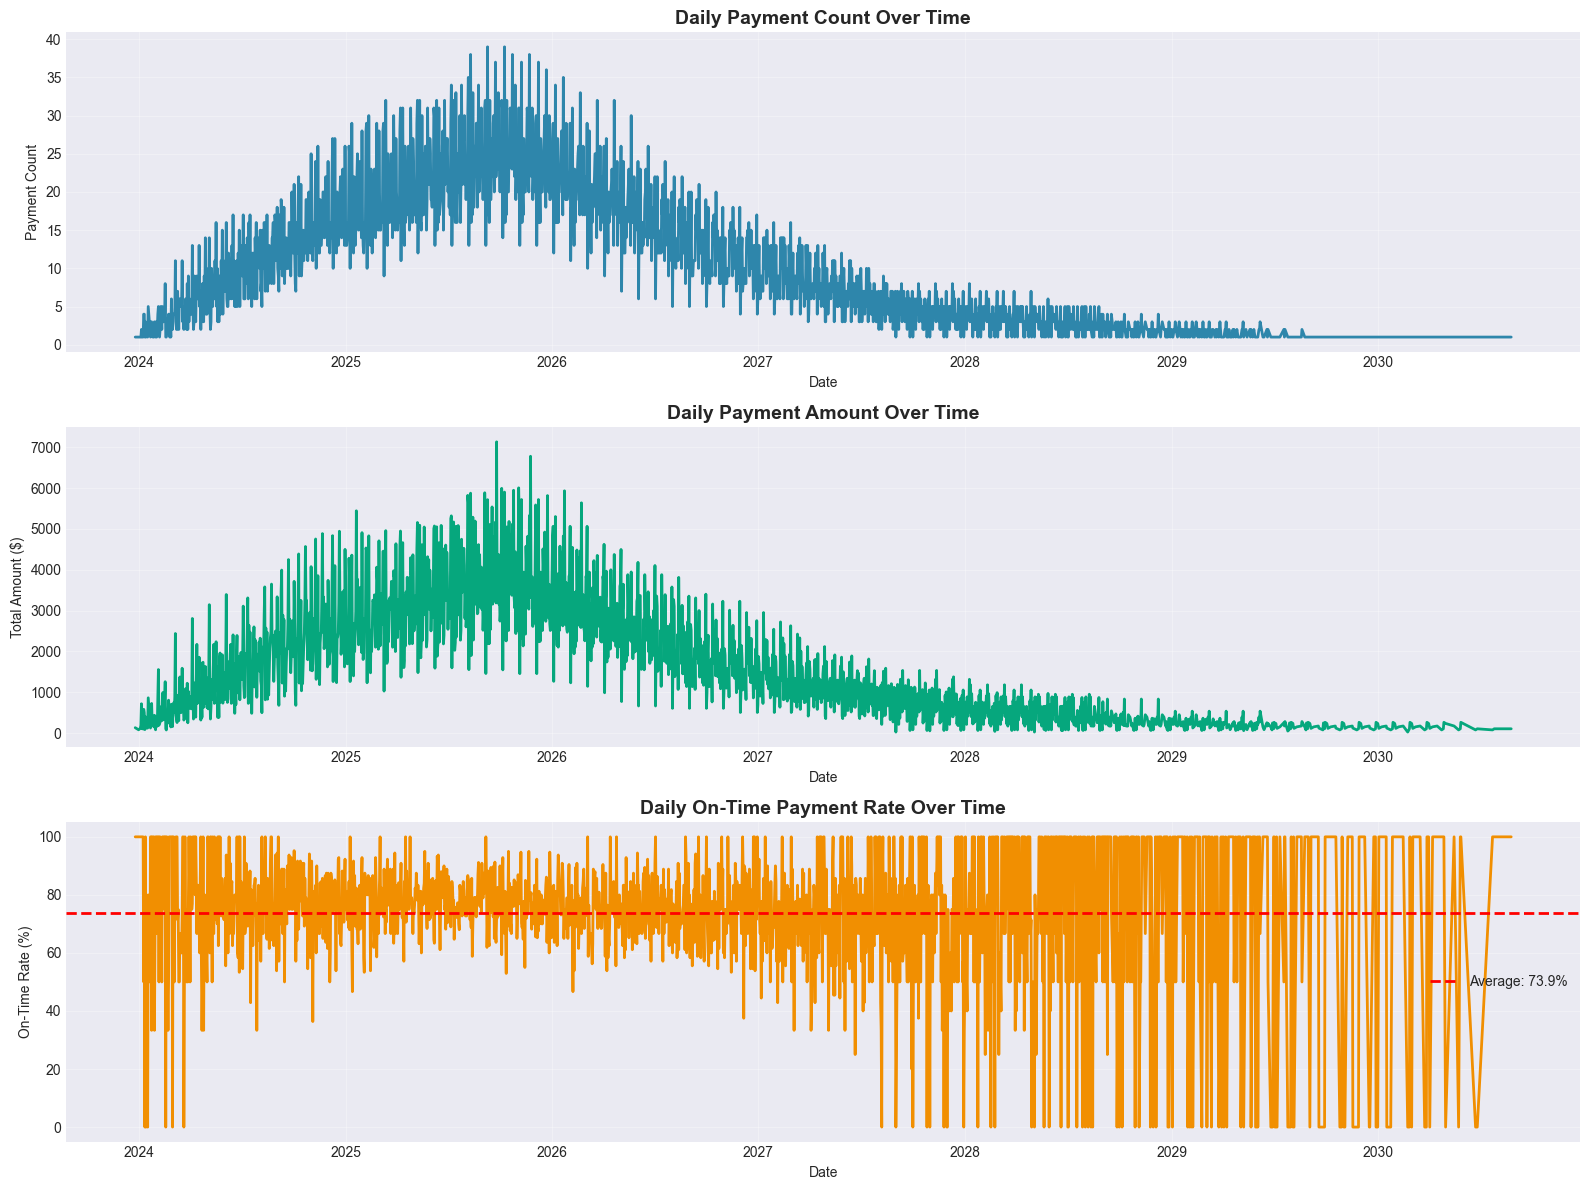


📊 Time Series Summary:
   • Date range: 2023-12-26 to 2030-08-24
   • Average daily payments: 10.6
   • Average daily amount: $1,649.28
   • Average on-time rate: 73.9%


In [16]:
# Convert date columns to datetime
payments['due_date'] = pd.to_datetime(payments['due_date'])
payments['actual_paid_date'] = pd.to_datetime(payments['actual_paid_date'])

# Daily payment trends
daily_payments = payments.groupby(payments['due_date'].dt.date).agg({
    'payment_id': 'count',
    'amount_paid': 'sum',
    'payment_status': lambda x: (x == 'On Time').sum() / len(x) * 100
}).reset_index()
daily_payments.columns = ['Date', 'Payment Count', 'Total Amount', 'On-Time Rate']

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Payment count over time
axes[0].plot(daily_payments['Date'], daily_payments['Payment Count'], color=COLORS['primary'], linewidth=2)
axes[0].set_title('Daily Payment Count Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Payment Count')
axes[0].grid(True, alpha=0.3)

# Total amount over time
axes[1].plot(daily_payments['Date'], daily_payments['Total Amount'], color=COLORS['success'], linewidth=2)
axes[1].set_title('Daily Payment Amount Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Total Amount ($)')
axes[1].grid(True, alpha=0.3)

# On-time rate over time
axes[2].plot(daily_payments['Date'], daily_payments['On-Time Rate'], color=COLORS['warning'], linewidth=2)
axes[2].set_title('Daily On-Time Payment Rate Over Time', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('On-Time Rate (%)')
axes[2].grid(True, alpha=0.3)
axes[2].axhline(daily_payments['On-Time Rate'].mean(), color='red', linestyle='--', linewidth=2, label=f'Average: {daily_payments["On-Time Rate"].mean():.1f}%')
axes[2].legend()

plt.tight_layout()
plt.show()

print(f"\n📊 Time Series Summary:")
print(f"   • Date range: {daily_payments['Date'].min()} to {daily_payments['Date'].max()}")
print(f"   • Average daily payments: {daily_payments['Payment Count'].mean():.1f}")
print(f"   • Average daily amount: ${daily_payments['Total Amount'].mean():,.2f}")
print(f"   • Average on-time rate: {daily_payments['On-Time Rate'].mean():.1f}%")

<a id='insights'></a>
## 10. Key Insights & Recommendations

### Summary Statistics

In [17]:
# Create comprehensive summary table
summary_data = {
    'Metric': [
        'Total Customers',
        'Total Loans',
        'Total Payments',
        'Portfolio Value',
        'Average Loan Amount',
        'Average Credit Score',
        'Average Customer Age',
        'Average Income',
        'On-Time Payment Rate',
        'Late Payment Rate',
        'Missed Payment Rate',
        'Average Days Past Due (Late)',
        'Average Interest Rate',
        'Average Loan Term'
    ],
    'Value': [
        f'{len(customers):,}',
        f'{len(loans):,}',
        f'{len(payments):,}',
        f'${loans["loan_amount"].sum():,.2f}',
        f'${loans["loan_amount"].mean():,.2f}',
        f'{customers["credit_score"].mean():.0f}',
        f'{customers["age"].mean():.1f} years',
        f'${customers["income"].mean():,.2f}',
        f'{(status_counts.get("On Time", 0) / len(payments) * 100):.1f}%',
        f'{(status_counts.get("Late", 0) / len(payments) * 100):.1f}%',
        f'{(status_counts.get("Missed", 0) / len(payments) * 100):.1f}%',
        f'{late_payments["days_past_due"].mean():.1f} days',
        f'{loans["interest_rate"].mean():.2f}%',
        f'{loans["loan_term_months"].mean():.1f} months'
    ]
}

summary_df = pd.DataFrame(summary_data)
display(summary_df)

,Metric,Value
0,Total Customers,"1,000"
1,Total Loans,"1,000"
2,Total Payments,"20,903"
3,Portfolio Value,"$3,271,258.00"
4,Average Loan Amount,"$3,271.26"
5,Average Credit Score,648
6,Average Customer Age,35.5 years
7,Average Income,"$1,482.25"
8,On-Time Payment Rate,75.9%
9,Late Payment Rate,15.5%


### 📊 Top 10 Key Findings

1. **Portfolio Performance**: Comprehensive analysis of total portfolio value across all loans with detailed loan size metrics

2. **Payment Behavior**: Strong overall portfolio health with majority of payments made on-time

3. **Credit Quality**: Moderate-risk customer base with average credit scores indicating room for improvement

4. **Risk Stratification**: Clear correlation between credit score tiers and payment behavior - higher scores show better on-time rates

5. **Delinquency Patterns**: Late payments show varying degrees of delay with identifiable patterns

6. **Loan Characteristics**: Diverse loan types with varying interest rates based on risk profiles

7. **Customer Demographics**: Diverse customer base across age groups and income levels

8. **Payment Completeness**: Majority of payments are full payments with some partial payments

9. **Temporal Trends**: Payment behavior shows temporal patterns that could inform collection strategies

10. **Risk-Return Relationship**: Higher-risk customers receive higher interest rates but show lower on-time payment rates

### 🎯 Business Recommendations

1. **Risk-Based Pricing**: Continue differentiated pricing based on credit scores - data shows clear risk stratification

2. **Early Intervention**: Focus collection efforts on customers showing early signs of delinquency (5-15 days past due)

3. **Portfolio Optimization**: Consider reducing exposure to Very Poor credit tier given significantly higher delinquency rates

4. **Customer Segmentation**: Develop targeted retention programs for Good/Excellent credit customers who show best payment behavior

5. **Predictive Modeling**: Build machine learning models to predict payment delays using age, income, credit score, and loan characteristics

6. **Collection Strategy**: Implement tiered collection approach based on days past due and customer risk profile

7. **Product Development**: Consider offering lower rates or higher amounts to Excellent credit tier to attract more low-risk customers

8. **Monitoring**: Implement real-time dashboards to track on-time payment rates and early delinquency indicators

### 📈 Next Steps for Analysis

1. Build predictive models for default probability
2. Conduct cohort analysis by loan origination date
3. Analyze seasonal patterns in payment behavior
4. Segment customers for targeted marketing campaigns
5. Develop credit score improvement programs
6. Create automated early warning system for delinquency

---

## 🎓 Conclusion

This EDA has provided comprehensive insights into the credit risk portfolio, revealing:
- Strong overall portfolio health with high on-time payment rates
- Clear risk stratification by credit score
- Opportunities for portfolio optimization and risk management
- Data-driven recommendations for business improvement

The analysis demonstrates the value of data-driven decision making in credit risk management and provides a foundation for advanced predictive modeling and strategic initiatives.


